#Text classification with an RNN<br>

### This text classification tutorial trains a recurrent neural network on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.


In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [44]:
#Import Tensorflow and tensorflow_datasets
# Importing data
from keras.datasets import imdb
# Importing text processing libraries
import pandas as pd
import numpy as np
import gensim
import spacy
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
# Importing libraries for model creation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN,Conv1D,MaxPool1D,Dropout,Input,LSTM,Dense,Flatten
from gensim.models.word2vec import Word2Vec
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
# Import `matplotlib` and create a helper function to plot graphs: Plot labels
import  matplotlib.pyplot as plt

In [1]:
root_path = '.'

In [37]:
data = pd.read_csv(root_path+"/IMDB.csv")

In [35]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [36]:
# Checking NA values 
data.isna().sum()

review       0
sentiment    0
dtype: int64

In [12]:
X = data.review
y = data.sentiment
# Setting positive sentiment as 1 and negative as 0
y = y.map({'positive':1,'negative':0})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
# processing the strings/ english sent
def preprocess(text):
    # Preprocessing and creating word tokens from a single sentence
    return gensim.utils.simple_preprocess(text)
# Removing stopwords
stopwords_ = stopwords.words("english")+list(punctuation)

def remove_stopwords(word_array):
    # Removing stopwords from a single sentence
    return [word for word in word_array if word not in stopwords_]
# Lemmatization
nlp = spacy.load('en')

def lemmatization(word_array, allow_postag= ['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Lemmatizing a single sentence
    sent = nlp(" ".join(word_array))
    # Allowin only noun pronoun verb and adjective to be present in the final text array
    return [word.lemma_ for word in sent if (word.pos_ in allow_postag)]

In [ ]:
# Preprocessing text
x_train = [lemmatization(remove_stopwords(preprocess(sent))) for sent in X_train]
x_test = [lemmatization(remove_stopwords(preprocess(sent))) for sent in X_test]

In [5]:
# or 
x_train, x_test, y_train, y_test = pd.read_pickle(root_path+"/IMDB.pkl")

In [124]:
# Getting the max number of words presnet in a sentence
max_sent_len = 0
len_summary = []
for dataset in [x_train,x_test]:
    for word_array in dataset:
        len_summary.append(len(word_array))

In [125]:
pd.Series(len_summary).describe()

count    50000.000000
mean        93.144140
std         69.830513
min          1.000000
25%         50.000000
50%         70.000000
75%        113.000000
max        981.000000
dtype: float64

In [8]:
# Sience 75% of the length falls under 113 words so we will consider 200 word length to get started
max_sent_len = 200

In [9]:
# Creating the voabulary using word to vec
embedding_len = 100
vocab  = Word2Vec(x_train,window=5,min_count=5,size = embedding_len)# For initial assumption the bow size have been kept to 4
# By default the embedding length is 100 , we can increase and decrease in order to improve the performance of the
# classification.

In [12]:
vocab_keys = vocab.wv.vocab.keys()
print('Vocabulary size: {}'.format(len(vocab_keys)))
# Crating a padding word and padding vec in case of the word present in sentence not found in our vocab
pad = "<PAD>"
padding_vec = np.random.uniform(-1,1,embedding_len)

Vocabulary size: 18066


In [13]:

# Function to get the embedding vectors
def get_embeddings(word_arry):
    len_word_mat = len(word_arry)
    vec_matrix = np.zeros((len_word_mat ,max_sent_len,embedding_len))

    for idx in range(len_word_mat):
        words = word_arry[idx]
        words = list(words)+[pad]*(max_sent_len-len(words))
        for jdx in range(max_sent_len):
            word = words[jdx]
            vec =None
            if(word in vocab_keys):
              vec = vocab.wv[word]
            if(vec is None): vec = padding_vec
            vec_matrix[idx][jdx] = vec
    return vec_matrix

In [14]:
# Getting the word embedded array vectors for train and test data
x_train = get_embeddings(x_train)
x_test = get_embeddings(x_test)

In [15]:
x_train.shape

(33500, 200, 100)

In [16]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [33]:
seq_model = Sequential()
seq_model.add(Input((max_sent_len,embedding_len)))
seq_model.add(Conv1D(filters = 32 , kernel_size = 4,activation='relu'))
seq_model.add(MaxPool1D(pool_size=2))
seq_model.add(Dropout(0.2))
seq_model.add(LSTM(50))
#seq_model.add(Flatten())
seq_model.add(Dense(1,activation='sigmoid'))
# Compile the Keras model to configure the training process and use a suitable optimizer
seq_model.compile(loss="binary_crossentropy",optimizer='adam')#Adam(1e-4))
seq_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 197, 32)           12832     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 98, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 29,483
Trainable params: 29,483
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Direcly load the model from weights file 
seq_model.load_weights(root_path+"/seq_model.h5")

In [60]:
## Train the model with 10 epochs and validation steps of 30
history = seq_model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=10)

Epoch 1/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1090
Epoch 2/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1121
Epoch 3/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1081
Epoch 4/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1090
Epoch 5/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1090
Epoch 6/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1103
Epoch 7/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1055
Epoch 8/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1028
Epoch 9/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1065
Epoch 10/10
524/524 [==============================] - 5s 9ms/step - loss: 0.1054


In [61]:
seq_model.save_weights(root_path+"/seq_model.h5")

In [54]:
print(history.history.keys())

dict_keys(['loss'])


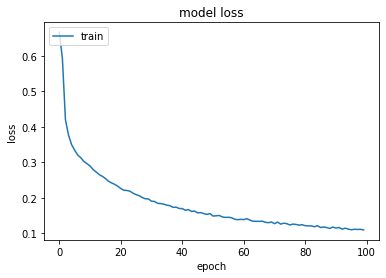

In [56]:
# Plotting history 
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
seq_model.evaluate(x_test,y_test)

516/516 [==============================] - 2s 5ms/step - loss: 0.4585


0.4585115909576416

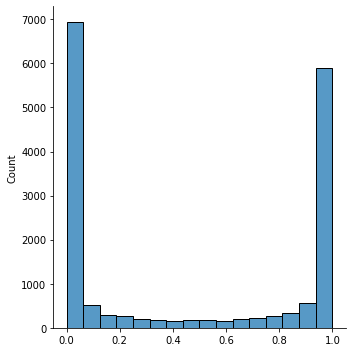

In [58]:
y_pred = seq_model.predict(x_test).reshape(1,-1)[0]
# from below graph we can observe that 0.5 is the best threshold 
sns.displot(y_pred)

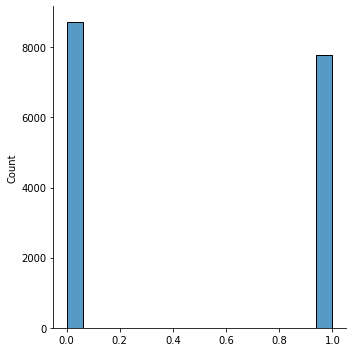

In [59]:
y_pred = (y_pred>0.5).astype('int32')
sns.displot(y_pred)

# Prediction and conclusion 
### Looking at the prediction scores , accuracy , precision and recall we can see that our model is doing pretty good :)

In [43]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[7267,  941],
       [1461, 6831]])

In [47]:
# Accuracy score
accuracy_score(y_test,y_pred)

0.8544242424242424

In [45]:
# Precision score
precision_score(y_test,y_pred)

0.8789243437982501

In [46]:
# Recall score
recall_score(y_test,y_pred)

0.8238060781476122

In [52]:
def sample_predict(sample_pred_text):
    word_array = lemmatization(remove_stopwords(preprocess(sample_pred_text)))
    embedding_array = get_embeddings([word_array])
    pred = seq_model.predict(embedding_array)
    if(pred>0.5):
      return 'positive'
    else:
      return 'negative'

In [57]:
# predict on a sample text
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text)
print(predictions)

positive
